In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize, sent_tokenize
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter

# Split the FindZebra corpus
The FindZebra corpus contrains a lot of different articles on rare and orphan diseases, each of which has a unique CUI linked to it. The CUI identifies which disease the article is about. The article might potentially be about more than one disease, but only one CUI is connected to it. Even though the whole article is about one disease, some parts of the article might be more relevant than others. In this notebook, every article will be split into several passages to use for both training and retrieval. Every article will be identified with a unique apid (article passage id), and every passage will be linked to the apid of the article it came from.

Further: Should I link METAMAP CUIs to the passages? Does that make sense?

### Load corpus and clean it

In [2]:
corpus_path = "/scratch/s190619/Data_etc/FindZebra/FZcorpus.csv"
df_ori = pd.read_csv(corpus_path,header=None)
df_ori.columns = ["source","source_url","title","raw_content","display_content","date","cui","meta-data"]

In [3]:
df_ori = df_ori.drop(["display_content","date"],axis=1)
df_ori.head()

,source,source_url,title,raw_content,cui,meta-data
0,gard,https://rarediseases.info.nih.gov/diseases/683...,Kernicterus,"<div id=""readSpeaker_Summary"">\n ...",C0022610,"{""mesh"": [""D007647""], ""umls"": [""C0022610""], ""o..."
1,gard,https://rarediseases.info.nih.gov/diseases/567...,47 XXX syndrome,"<div id=""readSpeaker_Summary"">\n ...",C0221033,"{""mesh"": [""C535318""], ""umls"": [""C0221033""], ""o..."
2,gard,https://rarediseases.info.nih.gov/diseases/964...,Pseudoxanthoma elasticum,"<div id=""readSpeaker_Summary"">\n ...",C0033847,"{""mesh"": [""D011561""], ""omim"": [""264800""], ""orp..."
3,gene_reviews,https://www.ncbi.nlm.nih.gov/books/NBK1310/,Smith-Magenis Syndrome,<h2>Summary</h2><div><h3>Clinical characterist...,C0795864,"{""mesh"": [""D058496""], ""synonyms"": [""del(17)(p1..."
4,gene_reviews,https://www.ncbi.nlm.nih.gov/books/NBK1143/,Smith-Lemli-Opitz Syndrome,<h2>Summary</h2><div><h3>Clinical characterist...,C0175694,"{""mesh"": [""D019082""], ""synonyms"": [""SLOS""]}"


In [4]:
import re

def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', raw_html)
    cleantext = " ".join(cleantext.split()) # Get rid of escape characters and excess spaces
    return cleantext

In [6]:
tqdm.pandas()
df_ori["clean_content"] = df_ori["raw_content"].progress_apply(lambda x: cleanhtml(x))

  0%|          | 0/30658 [00:00<?, ?it/s]

In [226]:
df_ori2 = df_ori.drop("raw_content",axis=1)
df_ori2 = df_ori2[["title","clean_content","cui","source","source_url","meta-data"]].reset_index()
df_ori2.columns = ["apid","title","clean_content","cui","source","source_url","meta-data"]
df_ori2.head(2)

,apid,title,clean_content,cui,source,source_url,meta-data
0,0,Kernicterus,Kernicterus refers to brain damage that may oc...,C0022610,gard,https://rarediseases.info.nih.gov/diseases/683...,"{""mesh"": [""D007647""], ""umls"": [""C0022610""], ""o..."
1,1,47 XXX syndrome,"47 XXX syndrome , also called trisomy X or tri...",C0221033,gard,https://rarediseases.info.nih.gov/diseases/567...,"{""mesh"": [""C535318""], ""umls"": [""C0221033""], ""o..."


In [234]:
#df_ori2.to_csv("/scratch/s190619/Data_etc/FindZebra/FZcorpus_CLEANED.tsv",sep="\t",index=False)

In [16]:
print(df_ori["raw_content"].iloc[0].replace("\n"," ")[:300])
print("\n\t\t\t=== cleanhtml() ===>\n")
print(df_ori["clean_content"].iloc[0][:300])

<div id="readSpeaker_Summary">                                           <strong>Kernicterus</strong> refers to brain damage that may occur when <a href="https://www.nlm.nih.gov/medlineplus/ency/article/001559.htm" target="_blank">neonatal jaundice</a> goes untreated for too long. Physiologic neonat

			=== cleanhtml() ===>

Kernicterus refers to brain damage that may occur when neonatal jaundice goes untreated for too long. Physiologic neonatal jaundice (which can affect about 60% of all newborn babies) is a very common condition in which the skin and whites of the eyes are yellowish in color within a few days after bi


In [235]:
#corpus_path = "/scratch/s190619/Data_etc/FindZebra/FZ_corpus_evaluation.tsv"
corpus_path = "/scratch/s190619/Data_etc/FindZebra/FZcorpus_CLEANED.tsv"
df = pd.read_csv(corpus_path, sep="\t")

In [236]:
df.columns = ['apid', 'title', 'article', 'cui', 'source', 'source_url', 'classification_map']
df.head()

,apid,title,article,cui,source,source_url,classification_map
0,0,Kernicterus,Kernicterus refers to brain damage that may oc...,C0022610,gard,https://rarediseases.info.nih.gov/diseases/683...,"{""mesh"": [""D007647""], ""umls"": [""C0022610""], ""o..."
1,1,47 XXX syndrome,"47 XXX syndrome , also called trisomy X or tri...",C0221033,gard,https://rarediseases.info.nih.gov/diseases/567...,"{""mesh"": [""C535318""], ""umls"": [""C0221033""], ""o..."
2,2,Pseudoxanthoma elasticum,"Pseudoxanthoma elasticum , PXE, is an inherite...",C0033847,gard,https://rarediseases.info.nih.gov/diseases/964...,"{""mesh"": [""D011561""], ""omim"": [""264800""], ""orp..."
3,3,Smith-Magenis Syndrome,Summary Clinical characteristics. Smith-Mageni...,C0795864,gene_reviews,https://www.ncbi.nlm.nih.gov/books/NBK1310/,"{""mesh"": [""D058496""], ""synonyms"": [""del(17)(p1..."
4,4,Smith-Lemli-Opitz Syndrome,Summary Clinical characteristics. Smith-Lemli-...,C0175694,gene_reviews,https://www.ncbi.nlm.nih.gov/books/NBK1143/,"{""mesh"": [""D019082""], ""synonyms"": [""SLOS""]}"


### Passage length
ColBERT prefers to take queries with a max length of 32, and documents with a max length of 180. Let's see how long a standard FZ article is

In [246]:
k = 0
for i in tqdm(range(1000)):
    k += len(word_tokenize(df["article"].iloc[i]))
print(k/1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1913.577


The documents are far too long. Let's find a good split. How about splitting with nltk?

  0%|          | 0/1000 [00:00<?, ?it/s]

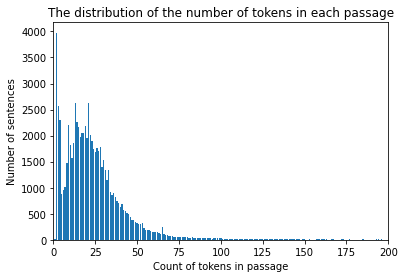

In [247]:
c = []
for i in tqdm(range(1000)):
    tmp = sent_tokenize(df["article"].iloc[i])
    for t in tmp:
        c.append(len(word_tokenize(t)))

c_keys = Counter(c).keys()
c_values = Counter(c).values()
plt.bar(c_keys,c_values)
plt.xlim(0,200)
plt.title("The distribution of the number of tokens in each passage")
plt.xlabel("Count of tokens in passage")
plt.ylabel("Number of sentences")
plt.show()
        

Using NLTK to split on sentences, seem to provide a short average length, but one that keeps the number of tokens below 180. Since ColBERT retrieves 1000 documents, it might be good that they are so short, at least for the task of MedQA's multiple choice.

### Split the articles with NLTK sentence tokeniser

In [58]:
tqdm.pandas()

In [62]:
df["passages"] = df["article"].progress_apply(lambda x: sent_tokenize(x))

  0%|          | 0/30658 [00:00<?, ?it/s]

In [63]:
df.head()

,apid,title,article,cui,source,source_url,classification_map,passages
0,0,Kernicterus,Kernicterusrefers to brain damage that may occ...,C0022610,gard,https://rarediseases.info.nih.gov/diseases/683...,"{""mesh"": [""D007647""], ""umls"": [""C0022610""], ""o...",[Kernicterusrefers to brain damage that may oc...
1,1,47 XXX syndrome,"47 XXX syndrome, also called trisomy X or trip...",C0221033,gard,https://rarediseases.info.nih.gov/diseases/567...,"{""mesh"": [""C535318""], ""umls"": [""C0221033""], ""o...","[47 XXX syndrome, also called trisomy X or tri..."
2,2,Pseudoxanthoma elasticum,"Pseudoxanthoma elasticum, PXE, is an inherited...",C0033847,gard,https://rarediseases.info.nih.gov/diseases/964...,"{""mesh"": [""D011561""], ""omim"": [""264800""], ""orp...","[Pseudoxanthoma elasticum, PXE, is an inherite..."
3,3,Smith-Magenis Syndrome,SummaryClinical characteristics.Smith-Magenis ...,C0795864,gene_reviews,https://www.ncbi.nlm.nih.gov/books/NBK1310/,"{""mesh"": [""D058496""], ""synonyms"": [""del(17)(p1...",[SummaryClinical characteristics.Smith-Magenis...
4,4,Smith-Lemli-Opitz Syndrome,SummaryClinical characteristics.Smith-Lemli-Op...,C0175694,gene_reviews,https://www.ncbi.nlm.nih.gov/books/NBK1143/,"{""mesh"": [""D019082""], ""synonyms"": [""SLOS""]}",[SummaryClinical characteristics.Smith-Lemli-O...


In [94]:
%%time
passages = []
apid = []
for i in tqdm(range(df.shape[0])):
    for sent in df["passages"].iloc[i]:
        passages.append(sent)
        apid.append(df["apid"].iloc[i])
        
df2 = pd.DataFrame(np.array([apid,passages]).T)
df2 = df2.reset_index()

  0%|          | 0/30658 [00:00<?, ?it/s]

CPU times: user 1min 9s, sys: 1min 16s, total: 2min 25s
Wall time: 2min 23s


In [95]:
df2.columns = ["pid","apid","passages"]
df2["apid"] = df2["apid"].astype(int)
df3 = df2.join(df[["apid","title","cui"]].set_index("apid"), on="apid")
df3.head()

,pid,apid,passages,title,cui
0,0,0,Kernicterusrefers to brain damage that may occ...,Kernicterus,C0022610
1,1,0,Physiologic neonatal jaundice (which can affec...,Kernicterus,C0022610
2,2,0,"However, in some babies, bilirubin levels may ...",Kernicterus,C0022610
3,3,0,Risk factors for severe jaundice and higher bi...,Kernicterus,C0022610
4,4,0,"After a few days of jaundice, toxic levels of ...",Kernicterus,C0022610


## Export to tsv
The full dataset is exported to use for end evaluation, and a subset containing only the unique pid and passages, are exported to be used as the retrieval corpus in FindZebra.

In [97]:
dir_path = "/scratch/s190619/Data_etc/FindZebra/"
save_full_name = "FZ_corpus_split_w_info.tsv"
save_retrieval_name = "FZ_corpus_split.tsv"

df3.to_csv(dir_path + save_full_name, sep="\t")
df3[["pid","passages"]].to_csv(dir_path + save_retrieval_name, sep="\t",header=False,index=False)

In [4]:
dir_path = "/scratch/s190619/Data_etc/FindZebra/"
save_full_name = "FZ_corpus_split_w_info.tsv"
save_retrieval_name = "FZ_corpus_split.tsv"

pd.read_csv(dir_path + save_retrieval_name, sep="\t").shape#.head()

(865260, 2)

# Get the most relevant passage from document using BM25

### Load queries

In [237]:
from rank_bm25 import BM25Okapi

In [238]:
q_path = "/scratch/s190619/Data_etc/MedQA/disorders_table_train.csv"
qs = pd.read_csv(q_path)
qs.head(1)

,qid,query,answer,options,meta_info,Disorder,CUI,TUI,short_category,long_category,description,cui_METAMAP
0,3,A pulmonary autopsy specimen from a 58-year-ol...,Thromboembolism,"{'A': 'Thromboembolism', 'B': 'Pulmonary ische...",step1,True,C0040038,T046,DISO,Disorders,Pathologic Function,['C0040038']


In [280]:
def rank_documents(q,a,docs, apid = None):
    # The sentences are very short, so (and to) conserve context, let each doc be the 
    # sentence + the preceding and exceding ones
    if len(docs) > 2:
        docs = [docs[i] + " " + docs[i+1] for i in range(0,len(docs)-1)]
    else:
        docs = docs
    docs = [x for x in docs if a in x]
    # Tokenise the corpus
    tokenised_corpus = [word_tokenize(x) for x in docs]
    qt = word_tokenize(q)
    # Get the most relevant compared to the query, using BM25
    bm25 = BM25Okapi(tokenised_corpus)
    doc_scores = bm25.get_scores(qt)
    if apid != None:
        ranking = np.array([[apid[i],list(docs)[i],doc_scores[i]] for i in range(len(docs))])
        rdf = pd.DataFrame(ranking)
        rdf.columns = ["apid","passage","score"]
    else:
        ranking = np.array([[list(docs)[i],doc_scores[i]] for i in range(len(docs))])
        rdf = pd.DataFrame(ranking)
        rdf.columns = ["passage","score"]
    rdf["score"] = rdf["score"].astype(float)
    rdf = rdf.sort_values(by="score",ascending=False)
    return rdf

In [250]:
q = qs["query"].iloc[0].lower()
a = qs["answer"].iloc[0].lower()

In [128]:
# Get articles that contain the answer
ps = df["article"][df["article"].str.contains(a)]
# Tokenise the corpus
tokenised_corpus = [word_tokenize(x) for x in ps]
qt = word_tokenize(q)
# Get the most relevant compared to the query, using BM25
bm25 = BM25Okapi(tokenised_corpus)
doc_scores = bm25.get_scores(qt)
ranking = np.array([[list(ps)[i],doc_scores[i]] for i in range(len(ps))])
#doc_scores = bm25.get_top_n(qt,tokenised_corpus,n=1)

In [134]:
rdf = pd.DataFrame(ranking)

In [149]:
rdf.columns = ["passage","score"]
rdf["score"] = rdf["score"].astype(float)
rdf = rdf.sort_values(by="score",ascending=False)
rdf.head(5)

,passage,score
31,Disease caused by severe acute respiratory syn...,133.352631
81,Death of a region of brain cells due to poor b...,130.078361
68,Sarcoidosis is a disease involving abnormal co...,130.045586
52,Overview about the effects of COVID-19 infecti...,129.848091
48,Blockage of one or more of the arteries to the...,128.726907


In [241]:
num1 = list(sent_tokenize(rdf["passage"].iloc[0]))
ranked = rank_documents(q,num1)

In [242]:
ranked

,passage,score
256,"In May 2020, George Gao, the director of the C...",59.695831
64,An acute cardiac injury was found in 12% of in...,58.613780
292,Research on the antimalarial drugs hydroxychlo...,52.617617
257,Traces of the virus have been found in wastewa...,52.556400
293,Because this is a well tested and widely avail...,52.453788
...,...,...
49,Several different clade nomenclatures have bee...,11.564277
142,Ultraviolet germicidal irradiation may also be...,11.564277
250,Phylogenetics estimates that SARS-CoV-2 arose ...,11.441921
276,By 15 June 79 cases were officially confirmed.,11.360822


In [281]:
# Get articles that contain the answer
df2 = df.copy()
df2["article"] = [x.lower() for x in df2["article"]]
ps = df2["article"][df2["article"].str.contains(a)]
apid = list(df2[df2["article"].str.contains(a)].loc[:,"apid"])
# Tokenise the corpus into sentences
sent_tokenised_corpus = [sent_tokenize(x) for x in ps]
# Get the top 1 sentence for each document
top_tokenised_corpus = [rank_documents(q,a,sent_tokenised_corpus[i])["passage"].iloc[0] for i in range(len(sent_tokenised_corpus))]

ranking = rank_documents(q,a,top_tokenised_corpus,apid)
#ranking["apid"] = apid

In [282]:
for i in range(20):
    print("\n",ranking["passage"].iloc[i])


 this type of embolism is known as a thromboembolism . complications can arise when a venous thromboembolism (commonly called a vte) lodges in the lung as a pulmonary embolism . supraphysiologic production of vegf from many follicles under the prolonged effect of hcg appears to be the specific key process underlying ohss. thus, while the woman accumulates fluid in the third space, primarily in the form of ascites , she actually becomes hypovolemic and is at risk for respiratory, circulatory (such as arterial thromboembolism since blood is now thicker), and renal problems.

 [2] [4] a study of more than 200,000 women came to the result that admission to inpatient care during pregnancy was associated with an 18-fold increase in the risk of venous thromboembolism (vte) during the stay, and a 6-fold increase in risk in the four weeks after discharge, compared with pregnant women who did not require hospitalization. [5] the study included women admitted to hospital for one or more days for

In [304]:
def get_most_relevant(q,a,df, K=25):
    df2 = df.copy()
    # Get articles that contain the answer
    ps = df2["article"][df2["article"].str.contains(a)]
    apid = list(df2[df2["article"].str.contains(a)].loc[:,"apid"])
    
    if len(ps) == 0:
        return []
    # Tokenise the corpus into sentences
    sent_tokenised_corpus = [sent_tokenize(x) for x in ps]
    # Get the top 1 sentence for each document
    top_tokenised_corpus = [rank_documents(q,a,sent_tokenised_corpus[i])["passage"].iloc[0] for i in range(len(sent_tokenised_corpus))]

    ranking = rank_documents(q,a,top_tokenised_corpus,apid)
    
    # Return the min of the top K (25) documents or all documents that have a score over the mean score.
    N = min(K, ranking[ranking["score"] > ranking["score"].mean()].shape[0])
    return list(ranking["passage"].iloc[0:N])
    

In [305]:
df2 = df.copy()
df2["article"] = [x.lower() for x in df2["article"]]
df3 = df2[["apid","article"]].copy()
top_passages = []
for i in tqdm(range(qs.shape[0])):
    q = qs["query"].iloc[i].lower()
    a = qs["answer"].iloc[i].lower()
    top_passages.append(get_most_relevant(q,a,df3,K=25))

  0%|          | 0/2616 [00:00<?, ?it/s]

/home/s190619/.conda/envs/colbert-v0.2/lib/python3.7/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


KeyboardInterrupt: 

In [306]:
qs.iloc[112]

qid                                                             414
query             A 52-year-old female with a history of poorly-...
answer                                                            D
options           {'A': 'A', 'B': 'B', 'C': 'C', 'D': 'D', 'E': ...
meta_info                                                     step1
Disorder                                                       True
CUI                                                        C3843456
TUI                                                            T033
short_category                                                 DISO
long_category                                             Disorders
description                                                 Finding
cui_METAMAP                                                      []
Name: 112, dtype: object

In [295]:
a

'Thromboembolism'

In [303]:
top_passages[0]

['this type of embolism is known as a thromboembolism . complications can arise when a venous thromboembolism (commonly called a vte) lodges in the lung as a pulmonary embolism . supraphysiologic production of vegf from many follicles under the prolonged effect of hcg appears to be the specific key process underlying ohss. thus, while the woman accumulates fluid in the third space, primarily in the form of ascites , she actually becomes hypovolemic and is at risk for respiratory, circulatory (such as arterial thromboembolism since blood is now thicker), and renal problems.',
 '[2] [4] a study of more than 200,000 women came to the result that admission to inpatient care during pregnancy was associated with an 18-fold increase in the risk of venous thromboembolism (vte) during the stay, and a 6-fold increase in risk in the four weeks after discharge, compared with pregnant women who did not require hospitalization. [5] the study included women admitted to hospital for one or more days f